In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

In [23]:
df = pd.read_excel('/Users/ylanki/Desktop/PNA/CatchValue Queries/Data/Catch_by_EEZ_for_distribution (2024-07-22).xlsx')

In [24]:
df.drop(df[['fleet_id','days_arch','days']],axis=1,inplace=True)
df.head()

,yr,gr_id,flag_id,ez_id,alb_c,bet_c,blm_c,bum_c,mls_c,skj_c,swo_c,yft_c,bet_arch_c,skj_arch_c,yft_arch_c
0,1990,G,JP,I6,9885,61,0,252,1926,8326,1026,49,0,0,0
1,1990,G,TW,I6,1859,0,0,0,0,0,0,0,0,0,0
2,1990,H,ID,ID,0,167,17,272,0,0,10,5247,134,0,4198
3,1990,H,PH,PH,0,278,90,315,0,0,158,9012,222,0,7210
4,1990,K,PH,PH,0,3962,0,0,0,9444,0,36049,3962,9444,36049


In [28]:
categorical_cols = ['gr_id', 'flag_id', 'ez_id']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

X = df_encoded.drop(['bet_c'], axis=1)
y = df_encoded['bet_c'] 

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [32]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [34]:
y_pred = linear_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Mean Squared Error: {mse}")
print(f"Linear Regression R-squared: {r2}")

Linear Regression Mean Squared Error: 444460.1092185876
Linear Regression R-squared: 0.6224481353889622


In [36]:
features = ['gr_id', 'flag_id', 'ez_id']
target_columns = ['alb_c', 'bet_c', 'blm_c', 'bum_c', 'mls_c', 'skj_c', 'swo_c', 'yft_c', 'bet_arch_c', 'skj_arch_c']

# Split features and targets
X = df[features]
y = df[target_columns]

In [38]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), features)
    ]
)

# Define a function to prepare a model pipeline
def create_pipeline(model):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

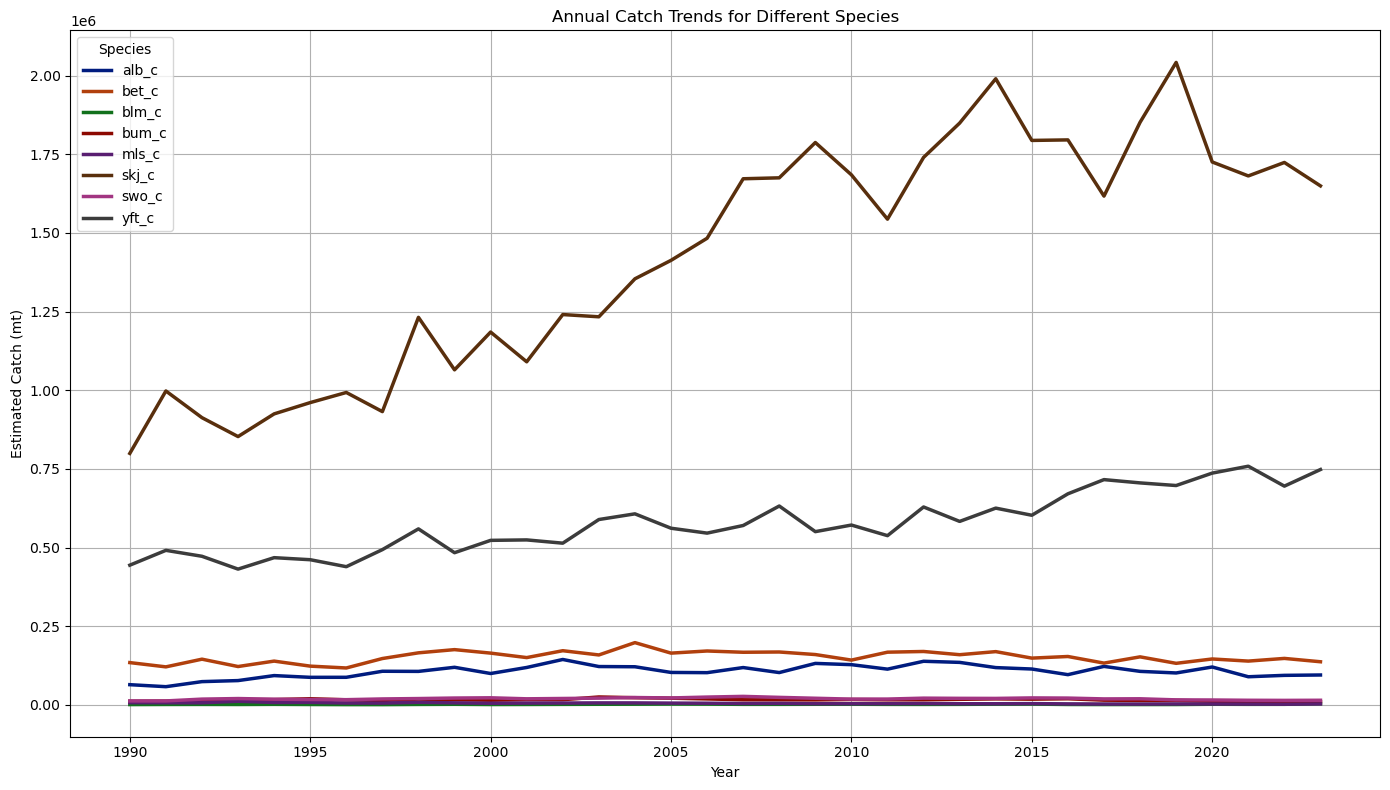

In [40]:
# Ensure 'yr' is numeric
df['yr'] = pd.to_numeric(df['yr'], errors='coerce')

# Drop rows where 'yr' or catch columns are NaN
df = df.dropna(subset=['yr'])

# Define species columns
species_columns = ['alb_c', 'bet_c', 'blm_c', 'bum_c', 'mls_c', 'skj_c', 'swo_c', 'yft_c']

# Aggregate the data by year for each species
annual_totals = df.groupby('yr')[species_columns].sum().reset_index()

# Plotting
plt.figure(figsize=(14, 8))
for species in species_columns:
    sns.lineplot(data=annual_totals,x='yr',y=species,label=species,linewidth=2.5,
                 color=sns.color_palette("dark")[species_columns.index(species)])

plt.title('Annual Catch Trends for Different Species')
plt.xlabel('Year')
plt.ylabel('Estimated Catch (mt)')
plt.legend(title='Species')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

00:08:18 - cmdstanpy - INFO - Chain [1] start processing
00:08:18 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydateti

<Figure size 1400x800 with 0 Axes>

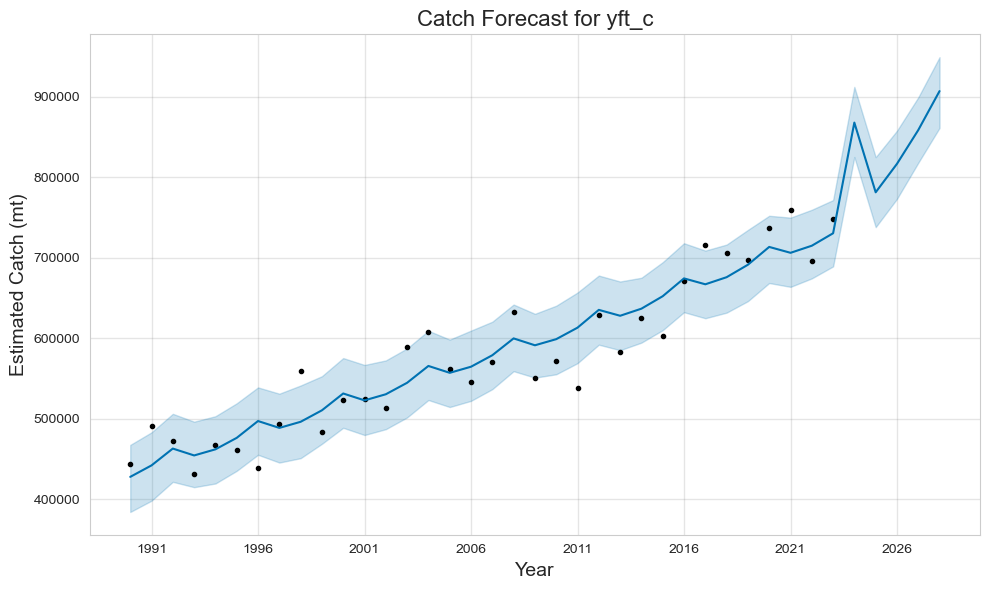

In [48]:
from prophet import Prophet

df['yr'] = pd.to_numeric(df['yr'], errors='coerce')
df = df.dropna(subset=['yr'])

# Define the species column to forecast
species = 'yft_c'

# Prepare the data for Prophet
# Create a DataFrame with columns 'ds' (date) and 'y' (value to forecast)
catch_data = df[['yr', species]].groupby('yr').sum().reset_index()
catch_data.columns = ['ds', 'y']
catch_data['ds'] = pd.to_datetime(catch_data['ds'], format='%Y')
# Initialize the Prophet model
model = Prophet(yearly_seasonality=True)

# Fit the model
model.fit(catch_data)

# Create a DataFrame with future dates to forecast
future = model.make_future_dataframe(periods=5, freq='Y')

# Forecast the future values
forecast = model.predict(future)

# Plot the historical data and forecast
sns.set_style('whitegrid')
plt.figure(figsize=(14, 8))
model.plot(forecast)

# Add title and labels
plt.title(f'Catch Forecast for {species}', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Estimated Catch (mt)', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

In [50]:
# Identify categorical variables to be encoded (e.g., 'gr_id', 'flag_id', 'ez_id')
categorical_cols = ['gr_id', 'flag_id', 'ez_id']

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Separate features (X) and target variable (y) 
# For example, predicting 'bet_c' (bigeye tuna catch)
X = df_encoded.drop(['bet_c'], axis=1)  # Features
y = df_encoded['bet_c']  # Target (Bigeye tuna catch)

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Model training - Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Step 6: Predictions on test data
y_pred = linear_model.predict(X_test)

# Step 7: Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Mean Squared Error: {mse}")
print(f"Linear Regression R-squared: {r2}")

Linear Regression Mean Squared Error: 318122.6150587748
Linear Regression R-squared: 0.6843340326305873


In [62]:
df.columns

Index(['gr_id', 'flag_id', 'ez_id', 'alb_c', 'bet_c', 'blm_c', 'bum_c',
       'mls_c', 'skj_c', 'swo_c', 'yft_c', 'bet_arch_c', 'skj_arch_c',
       'yft_arch_c'],
      dtype='object')

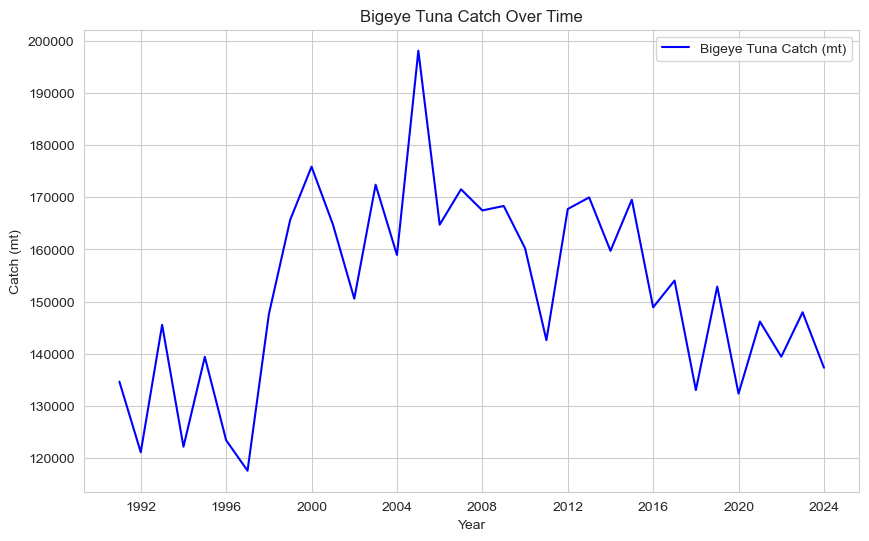

In [54]:
# Plot Bigeye Tuna catch over time
plt.figure(figsize=(10, 6))
plt.plot(df_yearly.index, df_yearly['bet_c'], label='Bigeye Tuna Catch (mt)', color='blue')
plt.title('Bigeye Tuna Catch Over Time')
plt.xlabel('Year')
plt.ylabel('Catch (mt)')
plt.legend()
plt.grid(True)
plt.show()

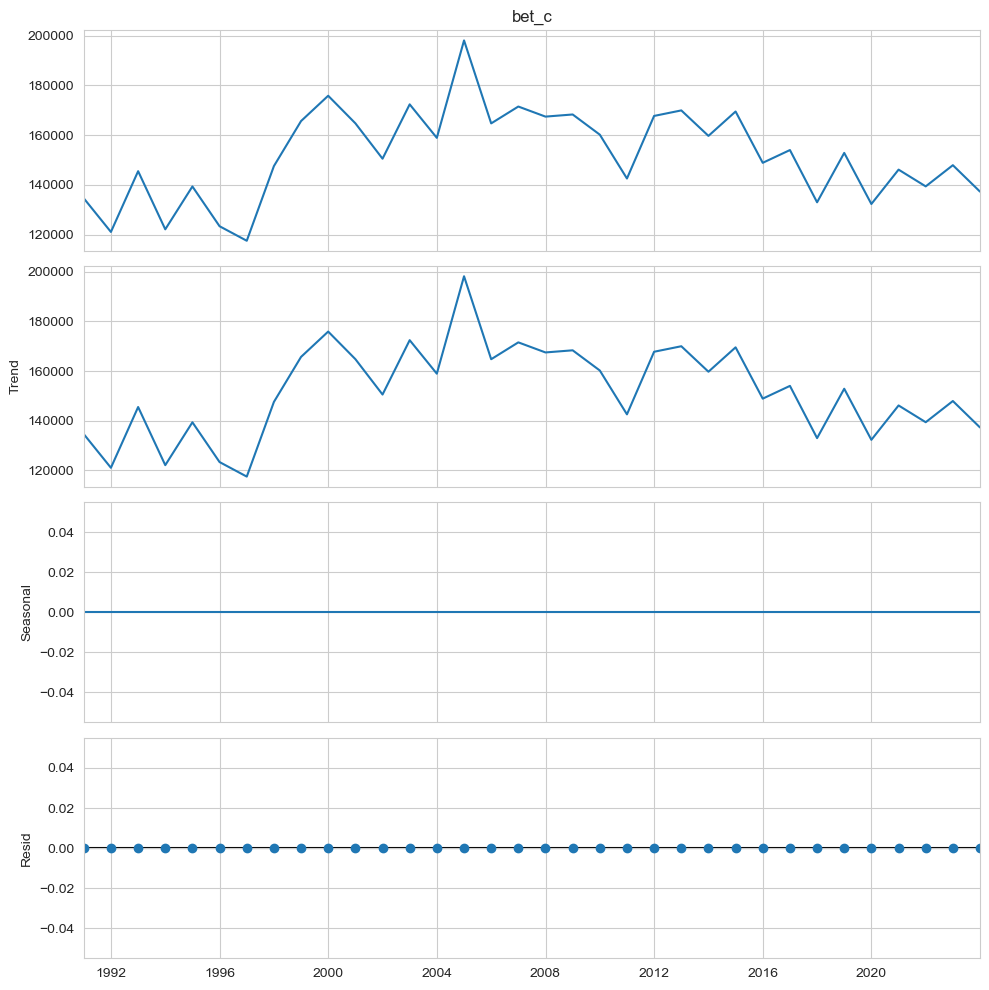

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(df_yearly['bet_c'], model='additive', period=1)

# Plot the decomposed components
plt.rcParams.update({'figure.figsize': (10, 10)})
decomposition.plot()
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  bet_c   No. Observations:                   34
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -364.205
Date:                Sat, 14 Sep 2024   AIC                            734.409
Time:                        16:37:29   BIC                            738.899
Sample:                    12-31-1990   HQIC                           735.920
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7021      0.217     -3.239      0.001      -1.127      -0.277
ma.L1          0.4986      0.251      1.984      0.047       0.006       0.991
sigma2      2.218e+08    6.9e-10   3.21e+17      0.0

/var/folders/4x/m1_kj_mj5dsfv_d9k7pjlnj80000gn/T/ipykernel_708/739675054.py:18: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  plt.plot(pd.date_range(df_yearly.index[-1], periods=5, freq='Y'), forecast, label='Forecasted Tuna Catch', color='red')


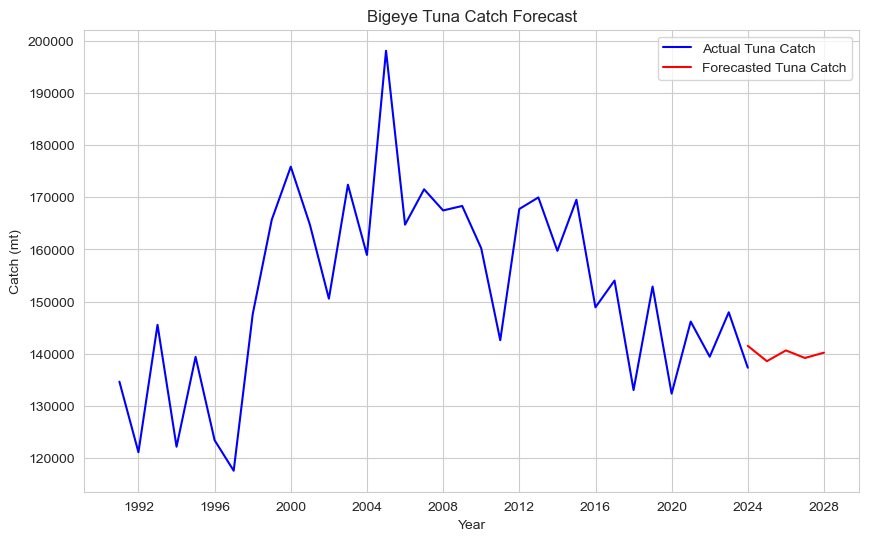

In [60]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Fit an ARIMA model (p=1, d=1, q=1) as an example
model = ARIMA(df_yearly['bet_c'], order=(1, 1, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Forecast future tuna catches
forecast = model_fit.forecast(steps=5)  # Forecast the next 5 periods (years)
print("Forecasted Tuna Catches:", forecast)

# Plot the actual values and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_yearly.index, df_yearly['bet_c'], label='Actual Tuna Catch', color='blue')
plt.plot(pd.date_range(df_yearly.index[-1], periods=5, freq='Y'), forecast, label='Forecasted Tuna Catch', color='red')
plt.title('Bigeye Tuna Catch Forecast')
plt.xlabel('Year')
plt.ylabel('Catch (mt)')
plt.legend()
plt.grid(True)
plt.show()